## Brief description of the notebook

In This notebook ,we aim for semi supervised ML algorithms for AD within our RabbitMQ.
 the dataset saas is the output of our previous processing and aggregation of features (notebook SaasV1Visualization&Generation)
For threshold definition we rely on chebyshev inequality
For validation, we use the chebyshev inequality threshold to build the ground truth, we use it along with confusion matrix and ROC-AUC to assess performance.

 
For Anomaly detection we rely on tools from PYOD Library ,which is a comprehensive and scalable Python toolkit for detecting outlying objects in multivariate data. for further reading https://pyod.readthedocs.io/en/latest/

for our case,We chose to apply two commonly used algorithms for AD:
    
     ISOLATION FOREST
         The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting
         a split value between the maximum and minimum values of the selected feature. 
     KNN
        kNN class for outlier detection. For an observation, its distance to its kth nearest neighbor could be
        viewed as the outlying score. It could be viewed as a way to measure the density. 
        
     LOF
         LOF Wrapper of scikit-learn LOF Class with more functionalities. 
         Unsupervised Outlier Detection using Local Outlier Factor (LOF).
    The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.
    
     OCSVM
         Wrapper of scikit-learn one-class SVM Class with more functionalities. Unsupervised Outlier Detection.
    Estimate the support of a high-dimensional distribution.
     
     COF
         Connectivity-Based Outlier Factor (COF) COF uses the ratio of average chaining distance of data point and 
         the average of average chaining distance of k nearest neighbor of the data point, as the outlier score for observations.

In [1]:
import pandas as pd  # manipulation et l'analyse des données
import numpy as np   #numpy pour manipuler les tableaux et faire des operations scientifiques

import matplotlib # pour  tracer et visualiser des données sous formes de graphiques
import matplotlib.pyplot as plt
import seaborn as sns # tracer et visualiser des données sous des formats avancées (statistique par exemple)

#Scipy : bibliotheque scientifique sous python
from scipy.stats import norm
from scipy.stats import kstest, norm #pour etudier la normalité des données
import scikitplot as skplt #outil de visualisation

#apprentissage:
#sklearn bibliotheque destinée à l'apprentissage automatique.
from sklearn.model_selection import train_test_split

#pyod :bibliotheque python dediée a la detection d'anomalie
from pyod.models.iforest import IForest #Isolation Forest
from pyod.models.knn import KNN     #K-Nearest-Neighbour
from pyod.models.lof import LOF    #Local Outlier Factor
from pyod.models.ocsvm import OCSVM  # One class SVM
from pyod.models.cof import COF       #Connectivity-based Outlier Factor

#Evaluation:
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
    classification_report, confusion_matrix
from pyod.utils.data import evaluate_print

In [2]:
%matplotlib inline
np.random.seed = 0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DEEA6B1F48>]],
      dtype=object)

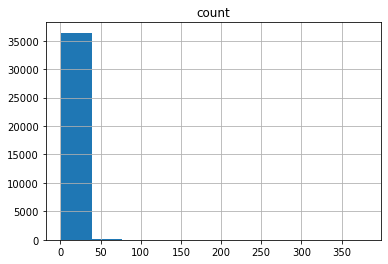

In [3]:
df =pd.read_csv("RabbitMQ.csv",parse_dates=['timestamp'] ,
                       index_col=['timestamp'])#comment if timestamp indexing not wanted
df_rabbitmq = df[['count']]
df_rabbitmq.hist()



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36593 entries, 2020-05-04 19:08:38 to 2020-06-26 15:44:00
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   routing_key                        36593 non-null  object
 1   headers.name                       36593 non-null  object
 2   headers.user_who_performed_action  36593 non-null  object
 3   count                              36593 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


## SaaS Data normality ,chebyshev rule and threshold

In [5]:
print("RabbitMQ data normality test")
ks_statistic, p_value = kstest(df_rabbitmq, 'norm')
print("ks_statistic " ,ks_statistic)
print("p_value " ,p_value)

RabbitMQ data normality test
ks_statistic  1.0
p_value  0.0


    The Test Statistic of the KS Test is the Kolmogorov Smirnov Statistic, which follows a 
    Kolmogorov distribution if the null hypothesis is true.

    If the observed data perfectly follow a normal distribution, the value of the KS statistic will be 0.
    The P-Value is used to decide whether the difference is large enough to reject the null hypothesis

    If the P-Value of the KS Test is larger than 0.05, we assume a normal distribution
    If the P-Value of the KS Test is smaller than 0.05, we do not assume a normal distribution

## “Chebyshev Bound”.

In [6]:
def find_anomalies(random_data):
    sigma = np.std(random_data)
    mu = np.mean(random_data)
    print('DATA MEAN :')
    print(mu)
    print('  STD : ')
    print(sigma)
    
    # Set upper and lower limit to 2 standard deviation
    print("")
    print('upper  value')
    upper_limit = mu+ (2*sigma)
    print(upper_limit)
    print('lower value')
    lower_limit = mu- (2*sigma)
    print(lower_limit)
    
    # Find outliers
    anomalies = []
    for outlier in random_data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return upper_limit,anomalies

In [7]:
lim , anom = find_anomalies(df['count'] )


DATA MEAN :
5.170087175142787
  STD : 
8.933889058907841

upper  value
23.037865292958468
lower value
-12.697690942672896


In [8]:
print("---------------------------------------------")
print("")
print(' Events outside of the upper limit per routing_key and headers.name, headers.user_who_performed_action per seconds-min-hour-day-month:  ')
evt_anom = df[ df['count'] > lim ]
evt_anom

#uncomment for further details about the data>threshold
#evt_anom =  df_saas[  df_saas['count'] > lim ]
#evt_anom

---------------------------------------------

 Events outside of the upper limit per user_id+clients per seconds-min-hour-day-month:  


,routing_key,headers.name,headers.user_who_performed_action,count
timestamp,,,,
2020-05-14 22:46:28,channel.created,10.238.22.7:49044 -> 10.238.22.5:5672 (1),bus-consolesaas,26
2020-05-14 22:48:28,channel.created,10.238.22.7:49044 -> 10.238.22.5:5672 (1),bus-consolesaas,26
2020-05-14 22:51:29,channel.created,10.238.22.7:49044 -> 10.238.22.5:5672 (1),bus-consolesaas,27
2020-05-15 22:02:12,channel.created,10.238.22.6:55420 -> 10.238.22.5:5672 (1),bus-consolesaas,59
2020-05-15 22:02:13,channel.created,10.238.22.6:55420 -> 10.238.22.5:5672 (1),bus-consolesaas,62
...,...,...,...,...
2020-06-20 22:03:14,channel.created,10.238.22.6:59072 -> 10.238.22.5:5672 (1),bus-consolesaas,50
2020-06-24 22:46:35,channel.created,10.238.22.7:38992 -> 10.238.22.5:5672 (1),bus-consolesaas,26
2020-06-24 22:54:01,channel.created,10.238.22.7:38992 -> 10.238.22.5:5672 (1),bus-consolesaas,28


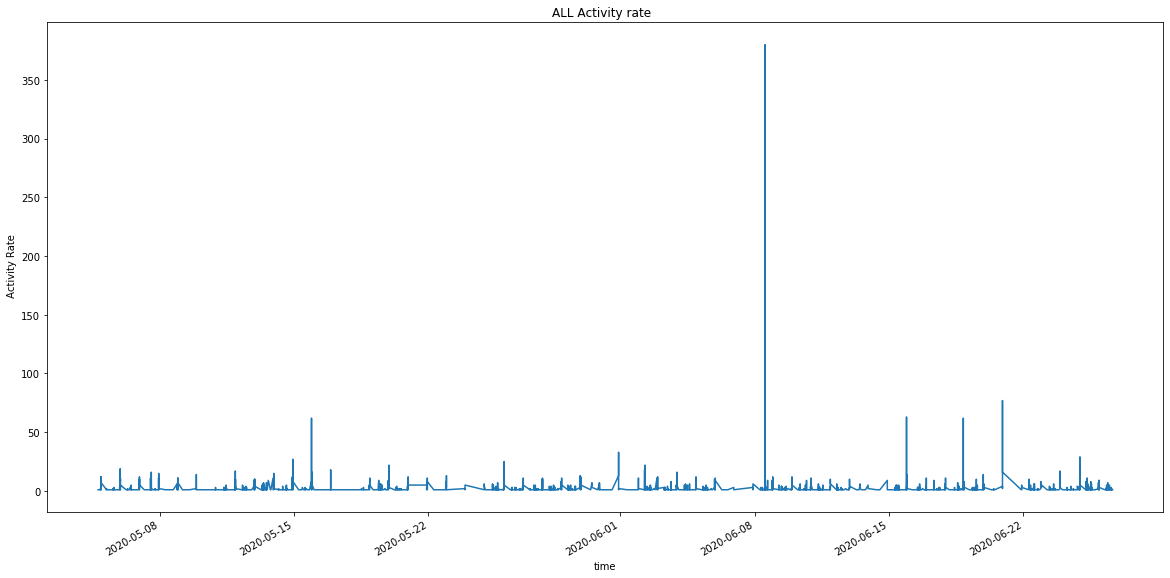

In [9]:

#plotting the count graphic/ figure 
df['count'].plot(#kind='line',
             figsize=(20, 10), # pass a tuple (x, y) size
             )

plt.title('ALL Activity rate  ')
plt.ylabel(' Activity Rate')
plt.xlabel('time')

plt.show() 

In [10]:
x = df['count']

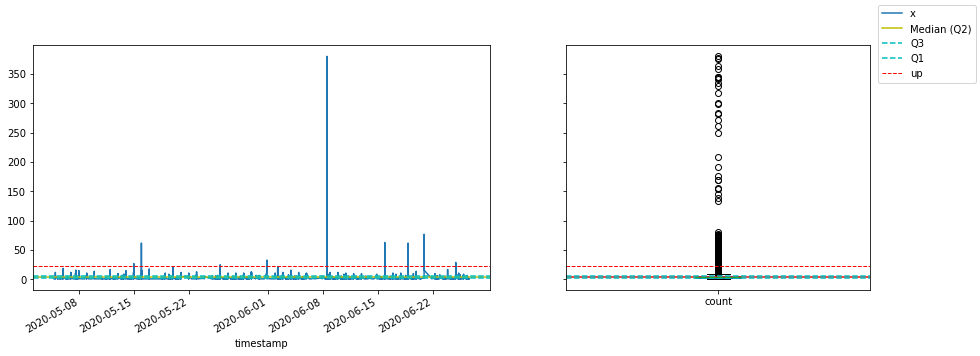

In [11]:
fig, axes = plt.subplots(1,2, figsize=(15,5), sharey=True, gridspec_kw={'width_ratios': [3, 2]})
# time plot with median Q1 and Q3 displayed

x.plot(ax=axes[0], label='x')
axes[0].axhline(x.median(), color='y', label='Median (Q2)')
axes[0].axhline(x.quantile(0.25), color='c', linestyle='--', label='Q3')
axes[0].axhline(x.quantile(0.75), color='c', linestyle='--', label='Q1')
axes[0].axhline(lim, color='r', linestyle='--', linewidth=1, label='up')
#axes[0].axhline(down_limit, color='r', linestyle='--', linewidth=1, label='down')


# boxplot
x.plot.box(ax=axes[1])
axes[1].axhline(x.median(), color='r')
axes[1].axhline(x.quantile(0.25), color='c', linestyle='--')
axes[1].axhline(x.quantile(0.75), color='c', linestyle='--')
axes[1].axhline(lim, color='r', linestyle='--', linewidth=1)
#axes[2].axhline(down_limit, color='r', linestyle='--', linewidth=1)
fig.legend();

le 1er quartile est la donnée de la série qui sépare les 25 % inférieurs des données (notation Q1) ;
le 2e quartile est la donnée de la série qui sépare les 50 % inférieurs des données (notation Q2) ; il est également appelé médiane ;
le 3e quartile est la donnée de la série qui sépare les 75 % inférieurs des données (notation Q3) 

La différence entre le troisième quartile et le premier quartile s'appelle écart interquartile ;
 c'est un critère de dispersion de la série. 


# ML OUTLIER DETECTION
## 1. Preparing data for outliers detection

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36593 entries, 2020-05-04 19:08:38 to 2020-06-26 15:44:00
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   routing_key                        36593 non-null  object
 1   headers.name                       36593 non-null  object
 2   headers.user_who_performed_action  36593 non-null  object
 3   count                              36593 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


## building the ground Truth

In [13]:
df.head()


,routing_key,headers.name,headers.user_who_performed_action,count
timestamp,,,,
2020-05-04 19:08:38,channel.created,10.238.22.7:35540 -> 10.238.22.5:5672 (1),bus-consolesaas,1
2020-05-04 19:09:53,channel.created,10.238.22.6:55420 -> 10.238.22.5:5672 (1),bus-consolesaas,1
2020-05-04 20:30:13,channel.created,10.238.22.6:55420 -> 10.238.22.5:5672 (1),bus-consolesaas,1
2020-05-04 20:33:58,channel.created,10.238.22.6:55420 -> 10.238.22.5:5672 (1),bus-consolesaas,1
2020-05-04 22:02:12,channel.created,10.238.22.6:55420 -> 10.238.22.5:5672 (1),bus-consolesaas,1


In [50]:
is_outlier = (x > lim)


df_rabbitmq = pd.concat([x, is_outlier], axis=1, keys=['x', 'is_outlier'])#we add the "labels" to our dataframe 
df_rabbitmq['is_outlier'].value_counts()

df_rabbitmq['is_outlier'].value_counts()

False    36342
True       251
Name: is_outlier, dtype: int64

In [51]:
print(f'Number of theoretical outliers: {len(df_rabbitmq[df_rabbitmq.is_outlier])}')
print(f'Number of theoretical  inliers: {len(df_rabbitmq[~df_rabbitmq.is_outlier])}') 
print(f'Percentage of outliers (contamination): {len(df_rabbitmq[df_rabbitmq.is_outlier]) * 1. / len(df_rabbitmq)}') 

Number of theoretical outliers: 251
Number of theoretical  inliers: 36342
Percentage of outliers (contamination): 0.0068592353728855245


In [53]:
#defining our y variable ,which we gonna use later for validation aka ground truth
y_true=df_rabbitmq.is_outlier.astype(int)
y =  y_true.copy()


### data normalisation

In [54]:
df = pd.read_csv('RabbitMQ.csv')

In [55]:
df.head()
df.shape

(36593, 5)

In [56]:
X = df['count']

# formating data for the algorithm (should be a 2D numpy array, see sklearn API)
X=x.values.reshape(-1, 1)

#When you do unsupervised learning, it is always a safe step to standardize the predictors
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)


In [57]:
X

array([[-0.46677177],
       [-0.46677177],
       [-0.46677177],
       ...,
       [-0.46677177],
       [-0.46677177],
       [-0.46677177]])

### Splitting train test set

In [58]:

# Split the dataset in two parts
#train set 70% of data
#test set 30% of data
#here, we are still in an unsupervised learning, we only add the ground truth (y_true) to the split_train_test so that
#we get correspond y_train and y_test to evaluate our train set x_train and testset x_test
X_train, X_test ,y_train ,y_test = train_test_split(X,y_true, test_size=0.3, random_state=42)


print('X_train: ' , X_train.shape )
print('X_test : ' , X_test.shape)
y_val =y_test.astype(int)

#print('y_train: ' , y_train.shape )
#print('y_test : ' , y_test.shape)

X_train:  (25615, 1)
X_test :  (10978, 1)


In [59]:
#we will need each of the testset and trainset lengths for building the corresponding results dataframes
l_test = X_test.size
l_train = X_train.size

In [60]:
df_test_plot = df_rabbitmq.tail(l_test) #dataframe for saving the Ml results on the testset

# ISOLATION FOREST PYOD VERSION

https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.iforest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest

In [61]:
df_train_plot = df_rabbitmq.head(l_train) #this dataframe is for saving th results of Ml model performed on trainset


In [62]:
# creating the outlier detector
clf_iforest = IForest(
    behaviour='new',
    random_state=47,
    n_estimators=100,#, # the number of base estimators
    #max_samples=0.8, #number of samples to draw from X to train each base estimator
    contamination=0.01, #proportion of outliers in the data set -->threshold to decision function
   # max_features=1.0
    
    )

I apply the trained model *mod* to predict the anomaly score for each observation in the test data.
How do we define an outlier? An outlier is a point that is distant from other points, so the outlier score is defined by distance. 
The PyOD function .decision_function() calculates the distance or the anomaly score for each data point.


In [63]:
%%time
# "fitting" the detector 
clf_iforest.fit(X_train)
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores = clf_iforest.decision_function(X_test )  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

Wall time: 1.25 s


0   -0.240971
1   -0.265321
2   -0.254099
3   -0.284251
4   -0.265321
dtype: float64

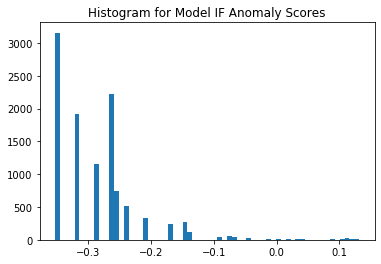

In [64]:
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model IF Anomaly Scores")
plt.show()

we use a histogram to count the frequency by the anomaly score, 

    in the X axis, the histogram shows the “score” values whoch are the average distance of those observations to others. High score (as 30) correspnding to low frequency -->evidence of outliers
    in the Y axis, the number of corresponding obsrvations/entrees

### On the TRAIN DATA

In [65]:
df_train_plot = df_rabbitmq.head(l_train) #this dataframe is for saving th results of Ml model performed on trainset
df_train_plot['isolation_forest_score'] = clf_iforest.decision_function(X_train)#calculate score of observations on trainset
df_train_plot['isolation_forest_outliers'] = clf_iforest.predict(X_train)#decide for observations based on their scores whether they are outliers or inliers
df_train_plot

C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,x,is_outlier,isolation_forest_score,isolation_forest_outliers
timestamp,,,,
2020-05-04 19:08:38,1,False,-0.318798,0
2020-05-04 19:09:53,1,False,-0.254099,0
2020-05-04 20:30:13,1,False,-0.318798,0
2020-05-04 20:33:58,1,False,-0.353242,0
2020-05-04 22:02:12,1,False,-0.353242,0
...,...,...,...,...
2020-06-03 22:48:12,5,False,-0.353242,0
2020-06-03 22:48:12,6,False,-0.318798,0
2020-06-03 22:48:13,5,False,-0.284251,0


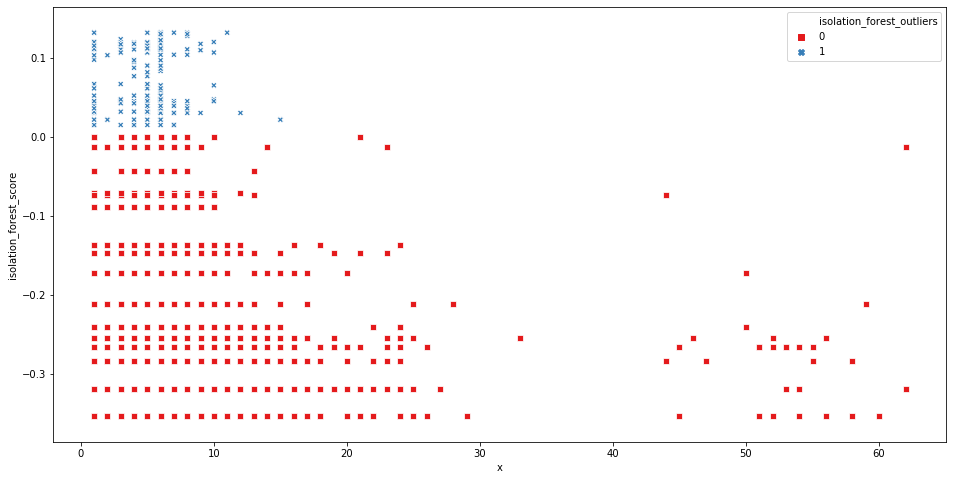

In [66]:
#scatterplot the obtained results on the trainset
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_train_plot, 
    x='x', 
    y='isolation_forest_score', 
    #hue='is_outlier',
    hue='isolation_forest_outliers',

    palette="Set1",
    sizes=(40, 200), #hue_norm=(0, 9),
    style='isolation_forest_outliers',
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values whoch are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

### on the TEST DATA

In [67]:
%%time
df_test_plot['isolation_forest_score'] = clf_iforest.decision_function(X_test)#calculate score for each observation in testset
df_test_plot['isolation_forest_outliers'] = clf_iforest.predict(X_test)# decide for calculated scores if an observation is an outlier or inlier

df_test_plot

Wall time: 352 ms


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,x,is_outlier,isolation_forest_score,isolation_forest_outliers
timestamp,,,,
2020-06-03 22:48:14,3,False,-0.240971,0
2020-06-03 22:48:15,6,False,-0.265321,0
2020-06-03 22:48:15,6,False,-0.254099,0
2020-06-03 22:48:16,5,False,-0.284251,0
2020-06-03 22:48:16,6,False,-0.265321,0
...,...,...,...,...
2020-06-26 15:00:43,1,False,-0.318798,0
2020-06-26 15:01:06,1,False,-0.353242,0
2020-06-26 15:07:34,1,False,-0.318798,0


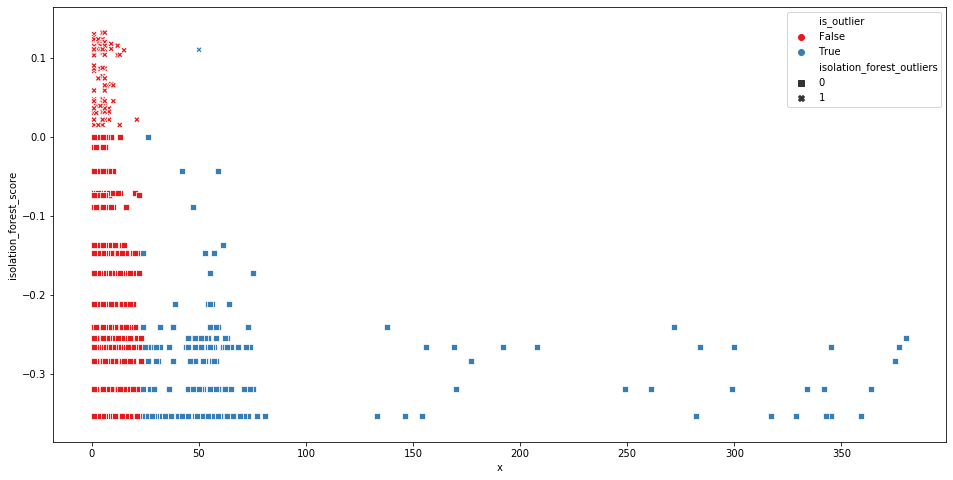

In [68]:
#plot the resuls on testset
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_test_plot, 
    x='x', 
    y='isolation_forest_score', 
    hue='is_outlier',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    style='isolation_forest_outliers',
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values which are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

#### Plot IF results on Test set with Ground Truth labels

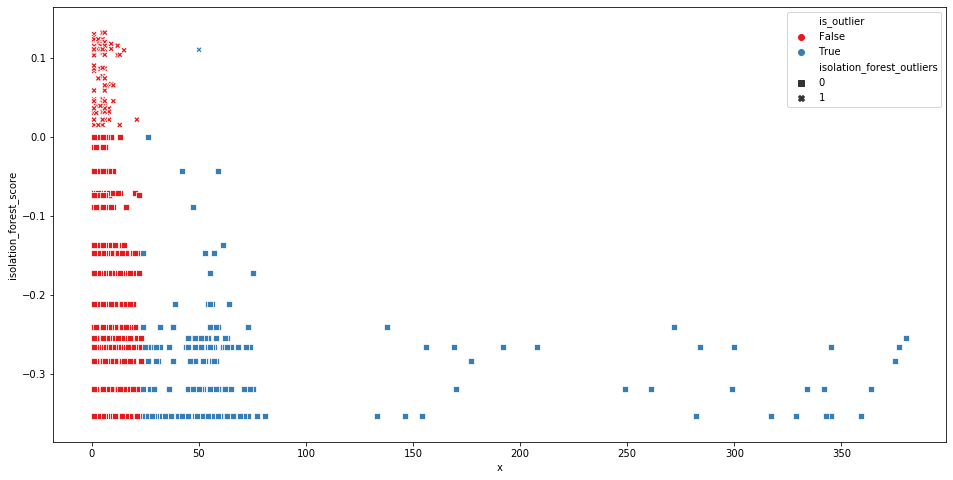

In [69]:
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_test_plot, 
    x='x', 
    y='isolation_forest_score', 
    hue='is_outlier',

    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    style='isolation_forest_outliers',
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values which are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

we add to the plot, the labels from the groundTruth so we can visually estimate how good/bad our model is

## Evaluating isolation forest algorithm


In [70]:
clf_name = 'Isolation Forest'
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, df_train_plot.isolation_forest_outliers)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, df_test_plot.isolation_forest_outliers)


On Training Data:
Isolation Forest ROC:0.9984, precision @ rank n:0.0

On Test Data:
Isolation Forest ROC:0.9983, precision @ rank n:0.0


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:


y_pred=df_test_plot.isolation_forest_outliers

#The F1 score: weighted average of the precision and recall, 
  #  where an F1 score reaches its best value at 1 and worst score at 0. 
  #  The relative contribution of precision and recall to the F1 score are equal.
    #F1 = 2 * (precision * recall) / (precision + recall)
print('f1_score ', f1_score(y_val
                            , y_pred, average="macro"))


#The precision is the ratio tp / (tp + fp) where tp is the number of true positives and 
#fp the number of false positives.
#The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
print('precision_score ',precision_score(y_val, y_pred, average="macro"))


#The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number 
#of false negatives.
#The recall is intuitively the ability of the classifier to find all the positive samples.
print('recall_score ',recall_score(y_val, y_pred, average="macro"))

f1_score  0.912294691357145
precision_score  0.852
recall_score  0.9983011937557392


In [72]:


confusion_matrix(y_val, y_pred=df_test_plot.isolation_forest_outliers )



array([[10853,    37],
       [    0,    88]], dtype=int64)

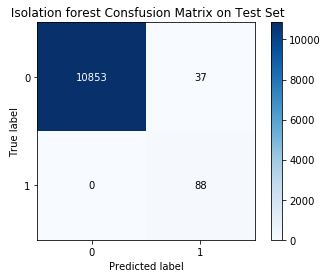

In [73]:


# plot the comfusion matrix  in the test set
y_preds = clf_iforest.predict(X_test)


skplt.metrics.plot_confusion_matrix(y_test,y_preds, normalize=False,
                                    title=" Isolation forest Consfusion Matrix on Test Set")
plt.show()

# K Nearest Neighbors
    https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.knn


In [74]:
clf_knn = KNN(
    contamination=0.01,
    n_neighbors=5,
    method='median',
    algorithm= 'ball_tree',
    #leaf_size=30,
    metric='minkowski'
)


In [75]:
%%time
clf_knn.fit(X_train) #adjust the model to trainset data
df_train_plot['KNN_score'] = clf_knn.decision_function(X_train)#calculate the scores for trainset
df_train_plot['KNN_outliers'] = clf_knn.predict(X_train)#decide for observations in trainset whether they are anomalies or normal 

df_train_plot



C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Wall time: 8.47 s


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,x,is_outlier,isolation_forest_score,isolation_forest_outliers,KNN_score,KNN_outliers
timestamp,,,,,,
2020-05-04 19:08:38,1,False,-0.318798,0,0.0,0
2020-05-04 19:09:53,1,False,-0.254099,0,0.0,0
2020-05-04 20:30:13,1,False,-0.318798,0,0.0,0
2020-05-04 20:33:58,1,False,-0.353242,0,0.0,0
2020-05-04 22:02:12,1,False,-0.353242,0,0.0,0
...,...,...,...,...,...,...
2020-06-03 22:48:12,5,False,-0.353242,0,0.0,0
2020-06-03 22:48:12,6,False,-0.318798,0,0.0,0
2020-06-03 22:48:13,5,False,-0.284251,0,0.0,0


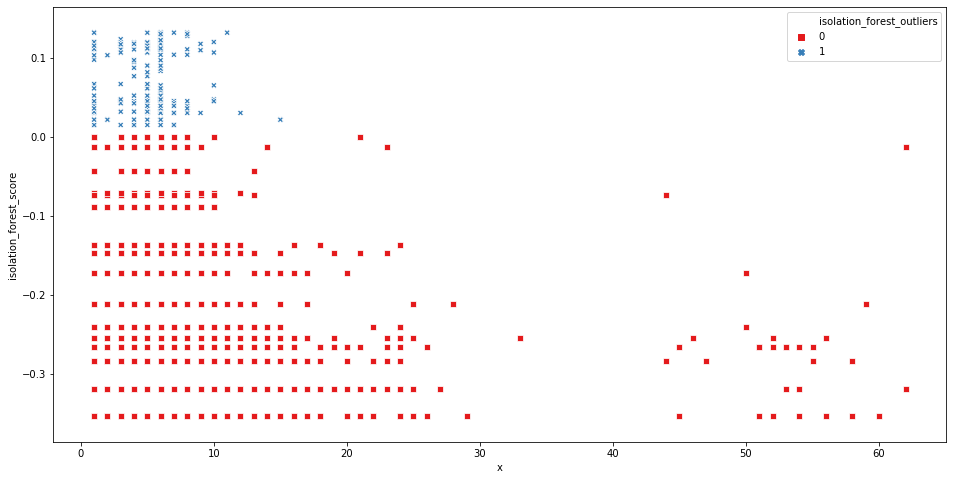

In [76]:
#scatterplot the obtained results on the trainset
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_train_plot, 
    x='x', 
    y='isolation_forest_score', 
    #hue='is_outlier',
    hue='isolation_forest_outliers',

    palette="Set1",
    sizes=(40, 200), #hue_norm=(0, 9),
    style='isolation_forest_outliers',
    markers= markers,
    ax=ax
)

in the X axis, the histogram shows the “score” values which are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
high scores tend to be at low frequency, which validates the assumption of outlier presence
in the Y axis, the number of corresponding obsrvations/entrees

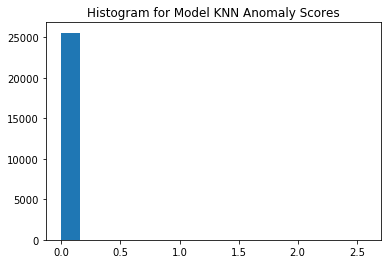

Wall time: 120 ms


In [77]:
%%time

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores =df_train_plot['KNN_score']  # outlier scores
y_test_scores = pd.Series(y_test_scores)

plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model KNN Anomaly Scores")
plt.show()


    in the X axis, the histogram shows the “score” values whoch are the average distance of those observations to others. 
    A high “score” means that observation is far away from the norm.
    high scores tend to be at low frequency, which validates the assumption of outlier presence
    in the Y axis, the number of corresponding obsrvations/entrees


In [78]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores = clf_knn.decision_function(X_test )  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores


# get the prediction on the test data

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.

df_test_plot['KNN_score'] = clf_knn.decision_function(X_test)
df_test_plot['KNN_outliers'] = clf_knn.predict(X_test)

df_test_plot

C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,x,is_outlier,isolation_forest_score,isolation_forest_outliers,KNN_score,KNN_outliers
timestamp,,,,,,
2020-06-03 22:48:14,3,False,-0.240971,0,0.0,0
2020-06-03 22:48:15,6,False,-0.265321,0,0.0,0
2020-06-03 22:48:15,6,False,-0.254099,0,0.0,0
2020-06-03 22:48:16,5,False,-0.284251,0,0.0,0
2020-06-03 22:48:16,6,False,-0.265321,0,0.0,0
...,...,...,...,...,...,...
2020-06-26 15:00:43,1,False,-0.318798,0,0.0,0
2020-06-26 15:01:06,1,False,-0.353242,0,0.0,0
2020-06-26 15:07:34,1,False,-0.318798,0,0.0,0


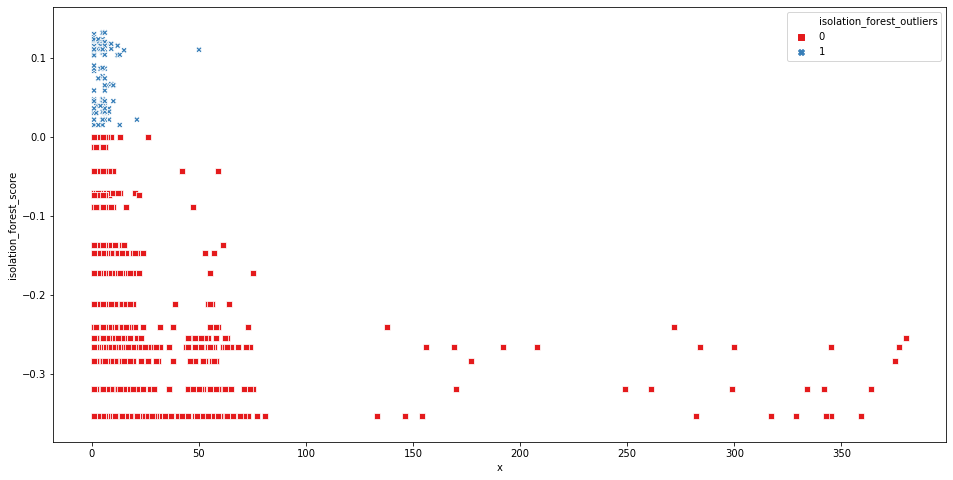

In [79]:
#plot the resuls on testset
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_test_plot, 
    x='x', 
    y='isolation_forest_score', 
     #hue='is_outlier',
    hue='isolation_forest_outliers',

    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    style='isolation_forest_outliers',
    markers= markers,
    ax=ax
)

in the X axis, the histogram shows the “score” values which are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
high scores tend to be at low frequency, which validates the assumption of outlier presence
in the Y axis, the number of corresponding obsrvations/entrees

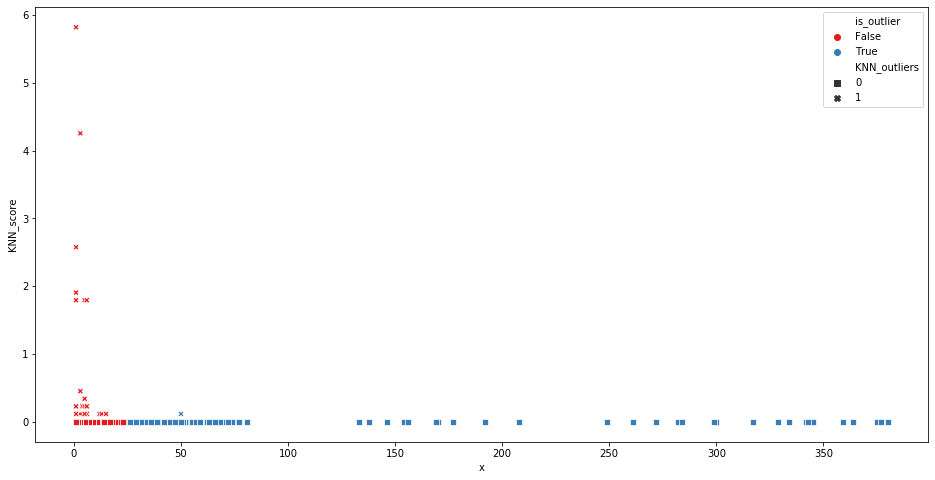

In [80]:
#scatterplot the results of the testset predictions with the groundtruth labels
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_test_plot, 
    x='x', 
    y='KNN_score', 
    hue='is_outlier',
    style='KNN_outliers',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values which are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

we add to the plot, the labels from the groundTruth so we can visually estimate how good/bad our model is

In [81]:


confusion_matrix(y_val, y_pred=df_test_plot.KNN_outliers )

y_pred=df_test_plot.KNN_outliers

#The F1 score: weighted average of the precision and recall, 
  #  where an F1 score reaches its best value at 1 and worst score at 0. 
  #  The relative contribution of precision and recall to the F1 score are equal.
    #F1 = 2 * (precision * recall) / (precision + recall)
print('f1_score ', f1_score(y_val, y_pred, average="macro"))


#The precision is the ratio tp / (tp + fp) where tp is the number of true positives and 
#fp the number of false positives.
#The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
print('precision_score ',precision_score(y_val, y_pred, average="macro"))


#The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number 
#of false negatives.
#The recall is intuitively the ability of the classifier to find all the positive samples.
print('recall_score ',recall_score(y_val, y_pred, average="macro"))

f1_score  0.8059642540101426
precision_score  0.9977603071578756
recall_score  0.7215909090909091


After training our KNN Detector model, we can get the prediction labels on the training data and then get the outlier scores of the training data. The higher the scores are, the more abnormal. This indicates the overall abnormality in the data. These features make PyOD a great utility for anomaly detection tasks.


In [82]:
# Get the prediction labels of the training data 
y_train_pred = clf_knn.predict(X_train) # binary labels (0: inliers, 1: outliers) # Outlier scores 
y_train_scores = clf_knn.decision_function(X_train)

y_test_scores = clf_knn.decision_function(X_test)  # outlier scores


We can evaluate KNN() with respect to the training data. PyOD provides a handy function for this task called evaluate_print(). The default metrics include ROC and Precision @ n. We will pass class name, y_train values and y_train_scores(outlier scores as returned by a fitted model.)


In [83]:
# Evaluate on the training data 
evaluate_print('KNN', y_train, y_train_scores)
# Evaluate on the test data
evaluate_print('KNN', y_test,y_test_scores)


KNN ROC:0.681, precision @ rank n:1.0
KNN ROC:0.7216, precision @ rank n:1.0


We will use decision_function to predict anomaly scores of the test set using the 
fitted detector(KNN Detector) and evaluate the results.


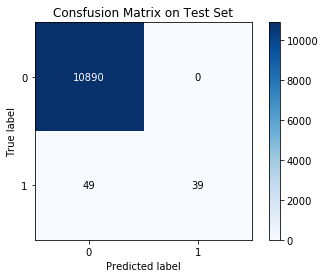

In [84]:
#Our KNN() model continues to perform well on the test set. Let’s plot the confusion matrix for the test set.

# plot the comfusion matrix  in the test set
y_preds = clf_knn.predict(X_test)

skplt.metrics.plot_confusion_matrix(y_val,y_preds, normalize=False,
                                    title="Consfusion Matrix on Test Set")
plt.show()

## LOF


In [85]:
clf_lof = LOF(
    algorithm='auto',
    n_neighbors=30 ,
    contamination=0.1,
    metric='minkowski',
    n_jobs=1)

#A quick tip: the square-root of the number of samples
    #is usually a good choice of n_neighbor so include it in GridSearchCV. 

                  

In [86]:
%%time

clf_lof.fit(X_train) #adjust the model to our trainset
#train visualization
df_train_plot['LOF_score'] = clf_lof.decision_function(X_train)#calculate scores for observations in the trainset
df_train_plot['LOF_outliers'] = clf_lof.predict(X_train)#decide if an observation is outlier/inlier based the score

df_train_plot


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Wall time: 2.36 s


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,x,is_outlier,isolation_forest_score,isolation_forest_outliers,KNN_score,KNN_outliers,LOF_score,LOF_outliers
timestamp,,,,,,,,
2020-05-04 19:08:38,1,False,-0.318798,0,0.0,0,1.0,0
2020-05-04 19:09:53,1,False,-0.254099,0,0.0,0,1.0,0
2020-05-04 20:30:13,1,False,-0.318798,0,0.0,0,1.0,0
2020-05-04 20:33:58,1,False,-0.353242,0,0.0,0,1.0,0
2020-05-04 22:02:12,1,False,-0.353242,0,0.0,0,1.0,0
...,...,...,...,...,...,...,...,...
2020-06-03 22:48:12,5,False,-0.353242,0,0.0,0,1.0,0
2020-06-03 22:48:12,6,False,-0.318798,0,0.0,0,1.0,0
2020-06-03 22:48:13,5,False,-0.284251,0,0.0,0,1.0,0


In [87]:
%%time

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores =clf_lof.decision_function(X_test )  # outlier scores
y_test_scores = pd.Series(y_test_scores)




Wall time: 338 ms


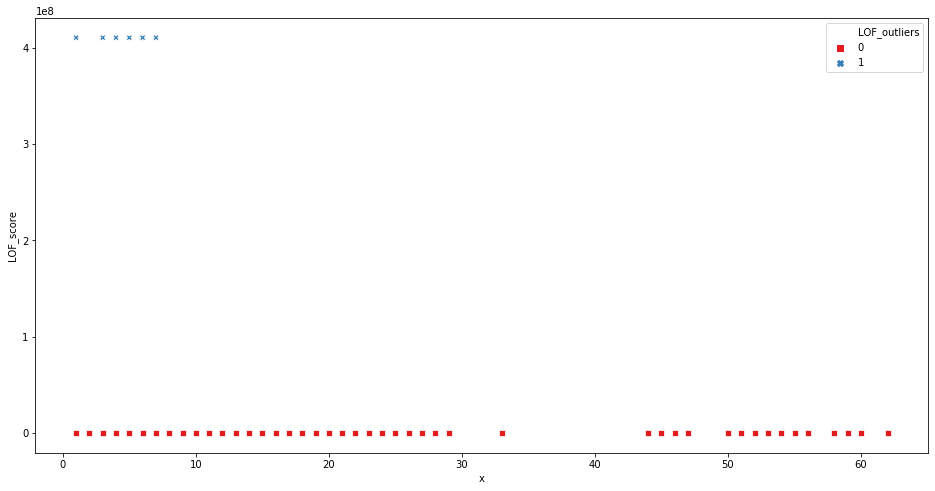

In [88]:
#scatterplot the results
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_train_plot, 
    x='x', 
    y='LOF_score', 
    #hue='is_outlier',
    hue='LOF_outliers',
    style='LOF_outliers',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values which are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable



In [90]:
# get the prediction on the test data

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores =  clf_lof.decision_function(X_test )  # outlier scores
#y_test_scores = pd.Series(y_test_scores)
y_test_pred =  clf_lof.predict(X_test)

df_test_plot['LOF_score'] = y_test_scores  
df_test_plot['LOF_outliers'] = y_test_pred 

df_test_plot

#df_test_plot['LOF_outliers'].value_counts()

C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,x,is_outlier,isolation_forest_score,isolation_forest_outliers,KNN_score,KNN_outliers,LOF_score,LOF_outliers
timestamp,,,,,,,,
2020-06-03 22:48:14,3,False,-0.240971,0,0.0,0,1.0,0
2020-06-03 22:48:15,6,False,-0.265321,0,0.0,0,1.0,0
2020-06-03 22:48:15,6,False,-0.254099,0,0.0,0,1.0,0
2020-06-03 22:48:16,5,False,-0.284251,0,0.0,0,1.0,0
2020-06-03 22:48:16,6,False,-0.265321,0,0.0,0,1.0,0
...,...,...,...,...,...,...,...,...
2020-06-26 15:00:43,1,False,-0.318798,0,0.0,0,1.0,0
2020-06-26 15:01:06,1,False,-0.353242,0,0.0,0,1.0,0
2020-06-26 15:07:34,1,False,-0.318798,0,0.0,0,1.0,0


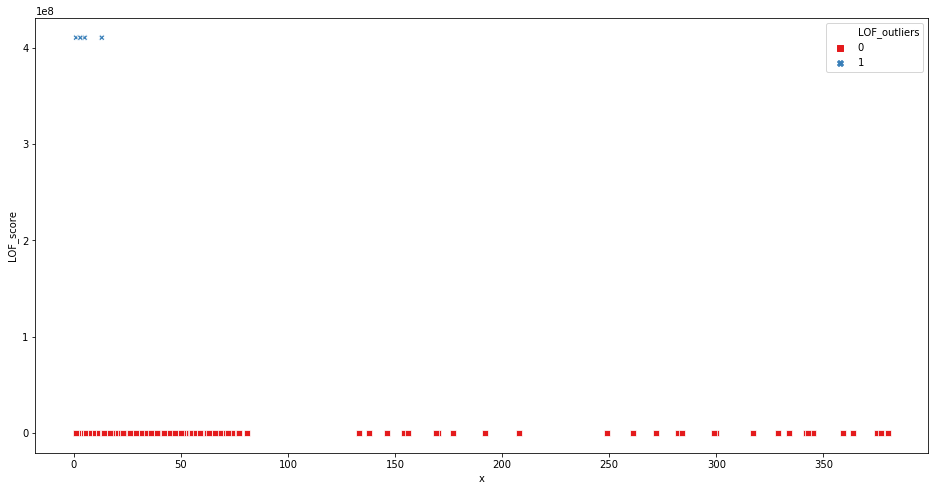

In [91]:
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_test_plot, 
     x='x', 
    y='LOF_score', 
    #hue='is_outlier',
    hue='LOF_outliers',
    style='LOF_outliers',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values which are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

we add to the plot, the labels from the groundTruth so we can visually estimate how good/bad our model is

#### test  visualization avec GroundTruth Labels


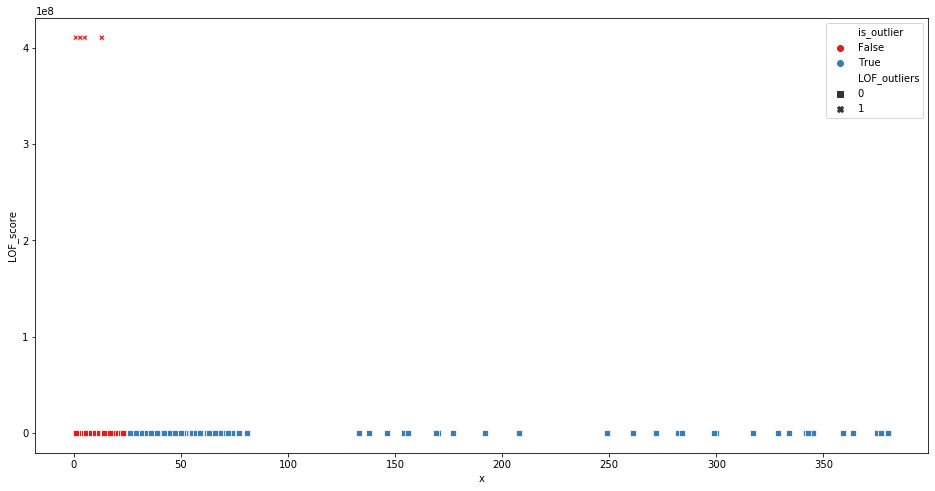

In [92]:
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_test_plot, 
     x='x', 
    y='LOF_score', 
    hue='is_outlier',
    style='LOF_outliers',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values which are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

we add to the plot, the labels from the groundTruth so we can visually estimate how good/bad our model is

In [93]:



confusion_matrix(y_val, y_pred=df_test_plot.LOF_outliers )

y_pred=df_test_plot.LOF_outliers

#The F1 score: weighted average of the precision and recall, 
  #  where an F1 score reaches its best value at 1 and worst score at 0. 
  #  The relative contribution of precision and recall to the F1 score are equal.
    #F1 = 2 * (precision * recall) / (precision + recall)
print('f1_score ', f1_score(y_val, y_pred, average="macro"))


#The precision is the ratio tp / (tp + fp) where tp is the number of true positives and 
#fp the number of false positives.
#The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
print('precision_score ',precision_score(y_val, y_pred, average="macro"))


#The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number 
#of false negatives.
#The recall is intuitively the ability of the classifier to find all the positive samples.
print('recall_score ',recall_score(y_val, y_pred, average="macro"))

f1_score  0.9093776731698107
precision_score  0.904866723814189
recall_score  0.9139921946740128


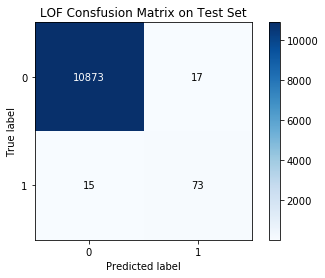

In [94]:
#Let’s plot the confusion matrix for the test set.

# plot the comfusion matrix  in the test set
skplt.metrics.plot_confusion_matrix(y_val,y_pred, normalize=False,
                                    title="LOF Consfusion Matrix on Test Set")
plt.show()

In [95]:
# Get the scores of the training data 
y_train_scores = clf_lof.decision_function(X_train)

# Get the prediction labels of the testing data 
y_test_scores = clf_lof.decision_function(X_test)  # outlier scores

# Evaluate on the trainset
evaluate_print('LOF', y_train, y_train_scores)

# Evaluate on the testset
evaluate_print('LOF', y_test,y_test_scores)


LOF ROC:0.7601, precision @ rank n:0.7134
LOF ROC:0.8292, precision @ rank n:0.7976


## OCSVM

In [96]:

clf_ocsvm = OCSVM(kernel='rbf',  gamma='auto',nu=0.5,
                  contamination=0.1,tol=0.001, degree = 6,
                shrinking=True, cache_size=200,
                verbose=True, max_iter=-1)


            

In [97]:
%%time
clf_ocsvm.fit(X_train)#adjust the model to our trainset

df_train_plot['OCSVM_score'] = clf_ocsvm.decision_function(X_train)#calculate scores for the trainset
df_train_plot['OCSVM_outliers'] = clf_ocsvm.predict(X_train)#decide

df_train_plot



[LibSVM]

C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Wall time: 23.4 s


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,x,is_outlier,isolation_forest_score,isolation_forest_outliers,KNN_score,KNN_outliers,LOF_score,LOF_outliers,OCSVM_score,OCSVM_outliers
timestamp,,,,,,,,,,
2020-05-04 19:08:38,1,False,-0.318798,0,0.0,0,1.0,0,-246.015937,0
2020-05-04 19:09:53,1,False,-0.254099,0,0.0,0,1.0,0,-131.890859,0
2020-05-04 20:30:13,1,False,-0.318798,0,0.0,0,1.0,0,-246.015937,0
2020-05-04 20:33:58,1,False,-0.353242,0,0.0,0,1.0,0,0.000085,0
2020-05-04 22:02:12,1,False,-0.353242,0,0.0,0,1.0,0,0.000085,0
...,...,...,...,...,...,...,...,...,...,...
2020-06-03 22:48:12,5,False,-0.353242,0,0.0,0,1.0,0,0.000085,0
2020-06-03 22:48:12,6,False,-0.318798,0,0.0,0,1.0,0,-246.015937,0
2020-06-03 22:48:13,5,False,-0.284251,0,0.0,0,1.0,0,-291.498583,0


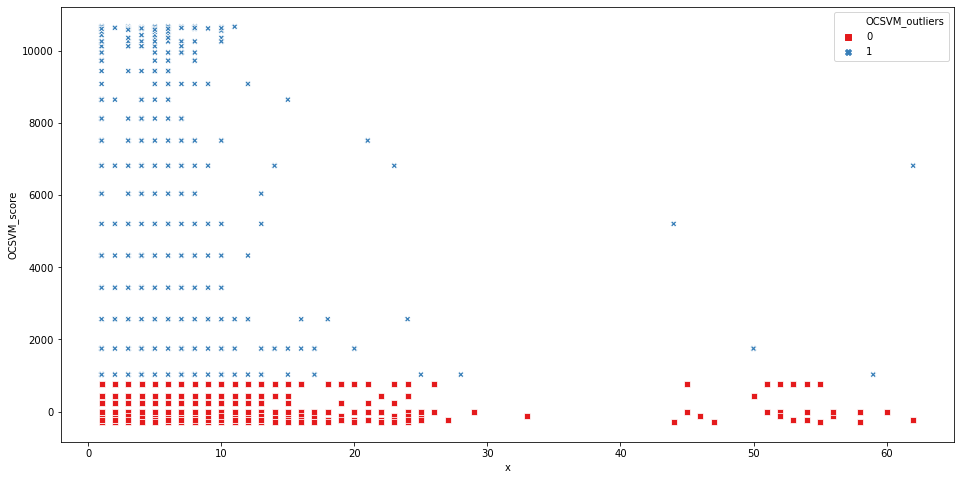

In [98]:
#scatterplot the results on the trainset
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_train_plot, 
    x='x', 
    y='OCSVM_score', 
    hue='OCSVM_outliers',
    style='OCSVM_outliers',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values which are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

In [99]:
%%time
# get the prediction on the test data

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores =  clf_ocsvm.decision_function(X_test )  # outlier scores
#y_test_scores = pd.Series(y_test_scores)
y_test_pred =  clf_ocsvm.predict(X_test)
y_test_scores



df_test_plot['OCSVM_score'] = y_test_scores  
df_test_plot['OCSVM_outliers'] = y_test_pred 

df_test_plot

#df_test_plot['COF_outliers'].value_counts()

Wall time: 3.24 s


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,x,is_outlier,isolation_forest_score,isolation_forest_outliers,KNN_score,KNN_outliers,LOF_score,LOF_outliers,OCSVM_score,OCSVM_outliers
timestamp,,,,,,,,,,
2020-06-03 22:48:14,3,False,-0.240971,0,0.0,0,1.0,0,431.367785,0
2020-06-03 22:48:15,6,False,-0.265321,0,0.0,0,1.0,0,765.209199,0
2020-06-03 22:48:15,6,False,-0.254099,0,0.0,0,1.0,0,-131.890859,0
2020-06-03 22:48:16,5,False,-0.284251,0,0.0,0,1.0,0,-291.498583,0
2020-06-03 22:48:16,6,False,-0.265321,0,0.0,0,1.0,0,765.209199,0
...,...,...,...,...,...,...,...,...,...,...
2020-06-26 15:00:43,1,False,-0.318798,0,0.0,0,1.0,0,-246.015937,0
2020-06-26 15:01:06,1,False,-0.353242,0,0.0,0,1.0,0,0.000085,0
2020-06-26 15:07:34,1,False,-0.318798,0,0.0,0,1.0,0,-246.015937,0


#### OCSVM  on testset 

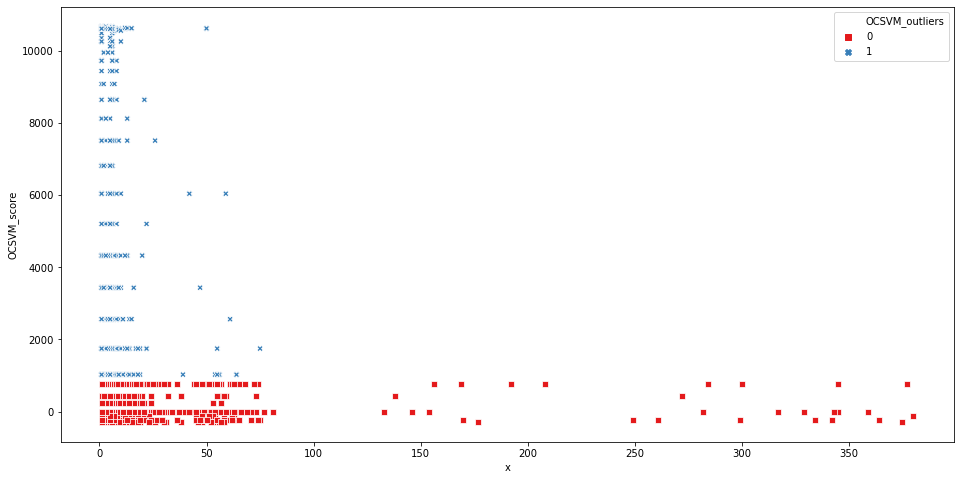

In [100]:
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_test_plot, 
    x='x', 
    y='OCSVM_score', 
    hue='OCSVM_outliers',
   
    style='OCSVM_outliers',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values whoch are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

#### OCSVM on test set with Ground Truth labels

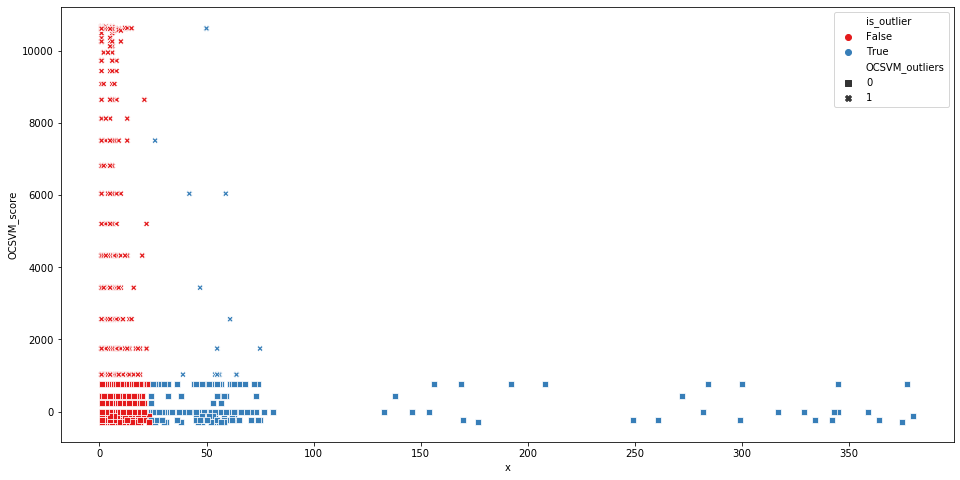

In [101]:
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_test_plot, 
    x='x', 
    y='OCSVM_score', 
    hue='is_outlier',
    style='OCSVM_outliers',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values which are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

we add to the plot, the labels from the groundTruth so we can visually estimate how good/bad our model is

In [102]:


y_pred=df_test_plot.OCSVM_outliers

#The F1 score: weighted average of the precision and recall, 
  #  where an F1 score reaches its best value at 1 and worst score at 0. 
  #  The relative contribution of precision and recall to the F1 score are equal.
    #F1 = 2 * (precision * recall) / (precision + recall)
print('f1_score ', f1_score(y_val, y_pred, average="macro"))


#The precision is the ratio tp / (tp + fp) where tp is the number of true positives and 
#fp the number of false positives.
#The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
print('precision_score ',precision_score(y_val, y_pred, average="macro"))


#The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number 
#of false negatives.
#The recall is intuitively the ability of the classifier to find all the positive samples.
print('recall_score ',recall_score(y_val, y_pred, average="macro"))

f1_score  0.5585356461547887
precision_score  0.5437810945273632
recall_score  0.9578971533516988


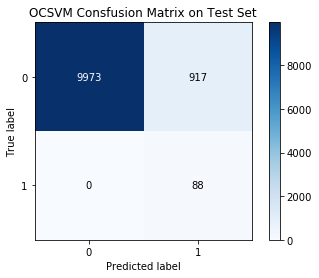

In [103]:
#Let’s plot the confusion matrix for the test set.

# plot the comfusion matrix  in the test set

skplt.metrics.plot_confusion_matrix(y_val,y_pred, normalize=False,
                                    title="OCSVM Consfusion Matrix on Test Set")
plt.show()

In [104]:
# Get the scores of the training data 
y_train_scores = clf_ocsvm.decision_function(X_train)

# Get the prediction labels of the testing data 
y_test_scores = clf_ocsvm.decision_function(X_test)  # outlier scores

In [105]:
# Evaluate on the trainset
evaluate_print('‘OCSVM’', y_train, y_train_scores)

# Evaluate on the testset
evaluate_print('OCSVM', y_test,y_test_scores)


‘OCSVM’ ROC:1.0, precision @ rank n:1.0
OCSVM ROC:1.0, precision @ rank n:1.0


## Connectivity-Based Outlier Factor (COF) Algorithm
Connectivity-Based Outlier Factor (COF) COF uses the ratio of average chaining distance of data point and the average of average chaining distance of k nearest neighbor of the data point, as the outlier score for observations.

In [106]:
clf_cof =COF(contamination=0.1, n_neighbors=2)


In [107]:
%%time
clf_cof.fit(X_train)#adjust our model to trainset
df_train_plot['COF_score'] = clf_cof.decision_function(X_train)#calculate the scores for trainset
df_train_plot['COF_outliers'] = clf_cof.predict(X_train) #decide for each observation

C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\pyod\models\cof.py:155: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(itemgetter(*sbn_path_index[_g])(ac_dist)))
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\pyod\models\cof.py:155: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(itemgetter(*sbn_path_index[_g])(ac_dist)))
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\numpy\core\_methods.py:183: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

Wall time: 15min 14s


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


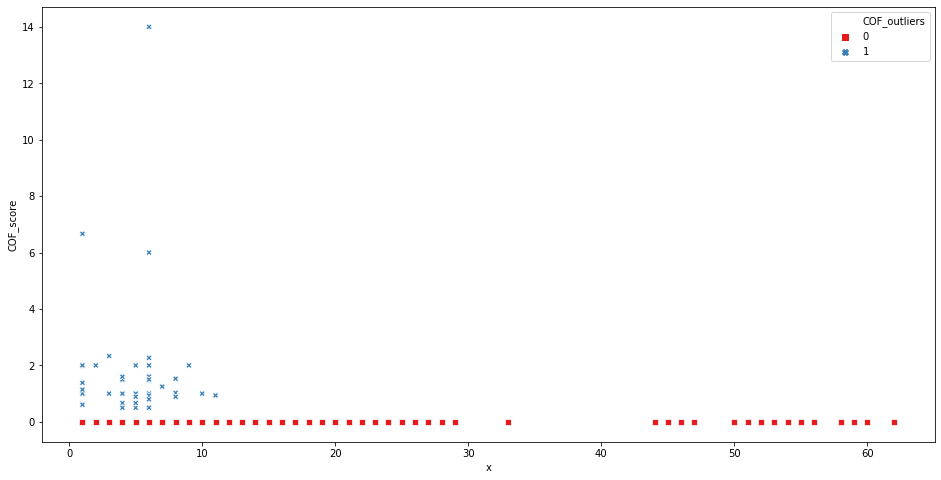

In [108]:
#plot the results on the trainset
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_train_plot, 
    x='x', 
    y='COF_score', 
   # hue='is_outlier',
    hue='COF_outliers',
    style='COF_outliers',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    markers= markers,
    ax=ax
)

In [109]:
%%time
# get the prediction on the test data

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores = clf_cof.decision_function(X_test )  # outlier scores
#y_test_scores = pd.Series(y_test_scores)
y_test_pred = clf_cof.predict(X_test)
y_test_scores


df_test_plot['COF_score'] = y_test_scores  
df_test_plot['COF_outliers'] = y_test_pred 

df_test_plot

#df_test_plot['COF_outliers'].value_counts()

Wall time: 1min 47s


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,x,is_outlier,isolation_forest_score,isolation_forest_outliers,KNN_score,KNN_outliers,LOF_score,LOF_outliers,OCSVM_score,OCSVM_outliers,COF_score,COF_outliers
timestamp,,,,,,,,,,,,
2020-06-03 22:48:14,3,False,-0.240971,0,0.0,0,1.0,0,431.367785,0,0.0,0
2020-06-03 22:48:15,6,False,-0.265321,0,0.0,0,1.0,0,765.209199,0,0.0,0
2020-06-03 22:48:15,6,False,-0.254099,0,0.0,0,1.0,0,-131.890859,0,0.0,0
2020-06-03 22:48:16,5,False,-0.284251,0,0.0,0,1.0,0,-291.498583,0,0.0,0
2020-06-03 22:48:16,6,False,-0.265321,0,0.0,0,1.0,0,765.209199,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26 15:00:43,1,False,-0.318798,0,0.0,0,1.0,0,-246.015937,0,0.0,0
2020-06-26 15:01:06,1,False,-0.353242,0,0.0,0,1.0,0,0.000085,0,0.0,0
2020-06-26 15:07:34,1,False,-0.318798,0,0.0,0,1.0,0,-246.015937,0,0.0,0


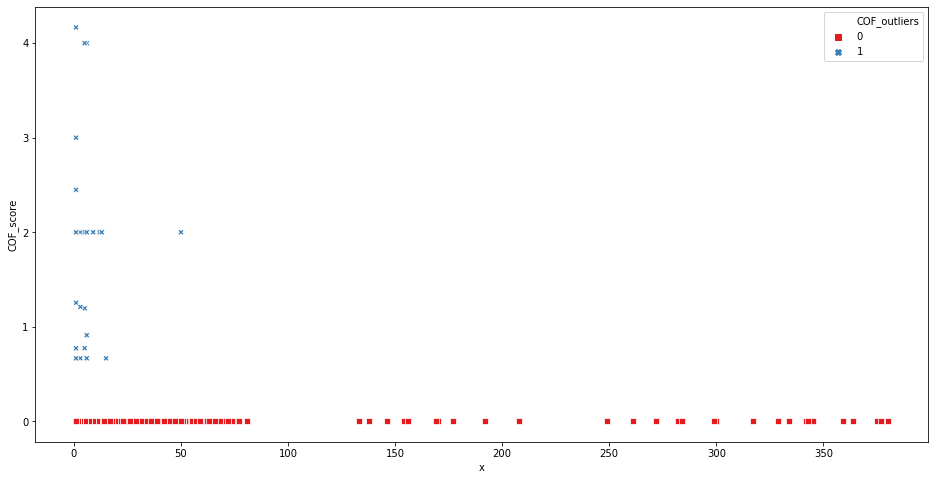

In [110]:
#plot the results on the testset
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_test_plot, 
    x='x', 
    y='COF_score', 
    hue='COF_outliers',
    style='COF_outliers',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values which are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

#### COF on testset avec Ground truth labels

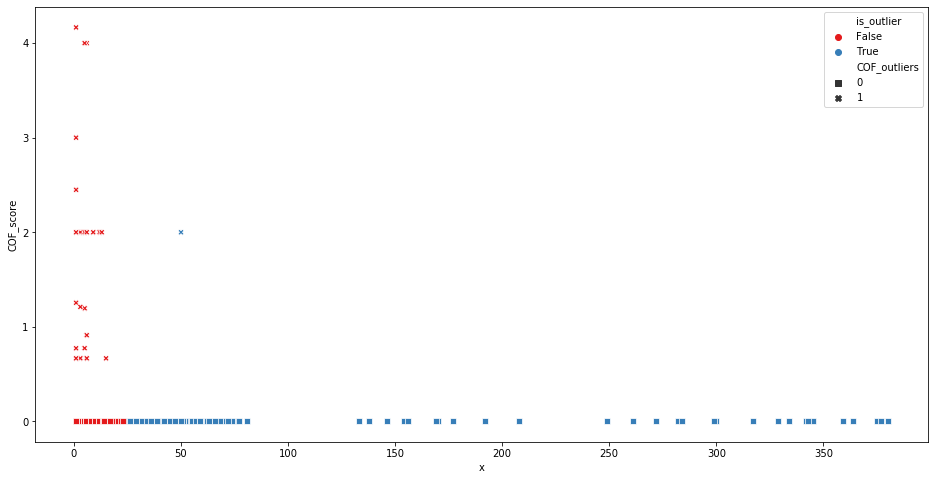

In [111]:
fig, ax = plt.subplots(figsize=(16,8))
markers = {0: "s", 1: "X"}
sns.scatterplot(
    data=df_test_plot, 
    x='x', 
    y='COF_score', 
    hue='is_outlier',
    style='COF_outliers',
    palette="Set1",
    sizes=(40, 200), hue_norm=(0, 9),
    markers= markers,
    ax=ax
)

in the Y axis, the plot shows the “score” values whoch are the average distance of those observations to others. 
A high “score” means that observation is far away from the norm.
in the X axis, the 'count ' values.
*note* in the training,fitting and prediction,the model uses normalized count values.Here, we only use non-normalized values to make the plot readable

In [112]:


#y_true=y_test.astype(int)
y_pred=df_test_plot.COF_outliers

confusion_matrix(y_val, y_pred )

#The F1 score: weighted average of the precision and recall, 
  #  where an F1 score reaches its best value at 1 and worst score at 0. 
  #  The relative contribution of precision and recall to the F1 score are equal.
    #F1 = 2 * (precision * recall) / (precision + recall)
print('f1_score ', f1_score(y_val, y_pred, average="macro"))


#The precision is the ratio tp / (tp + fp) where tp is the number of true positives and 
#fp the number of false positives.
#The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
print('precision_score ',precision_score(y_val, y_pred, average="macro"))


#The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number 
#of false negatives.
#The recall is intuitively the ability of the classifier to find all the positive samples.
print('recall_score ',recall_score(y_val, y_pred, average="macro"))

f1_score  0.8059642540101426
precision_score  0.9977603071578756
recall_score  0.7215909090909091


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\pyod\models\cof.py:155: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(itemgetter(*sbn_path_index[_g])(ac_dist)))
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\pyod\models\cof.py:155: RuntimeWarning: divide by zero encountered in double_scalars
  np.sum(itemgetter(*sbn_path_index[_g])(ac_dist)))


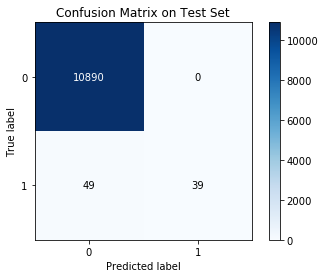

In [113]:
#Let’s plot the confusion matrix for the test set.

# plot the comfusion matrix  in the test set
y_preds = clf_cof.predict(X_test)

skplt.metrics.plot_confusion_matrix(y_test,y_preds, normalize=False,
                                    title="Confusion Matrix on Test Set")
plt.show()

In [114]:
# Get the scores of the training data 
y_train_scores = clf_cof.decision_function(X_train)

# Get the prediction labels of the testing data 
y_test_scores = clf_cof.decision_function(X_test)  # outlier scores

# Evaluate on the trainset
evaluate_print('‘COF’', y_train, y_train_scores)

# Evaluate on the testset
evaluate_print('COF', y_test,y_test_scores)

‘COF’ ROC:0.681, precision @ rank n:1.0
COF ROC:0.7216, precision @ rank n:1.0


C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## Evaluation of implemented models

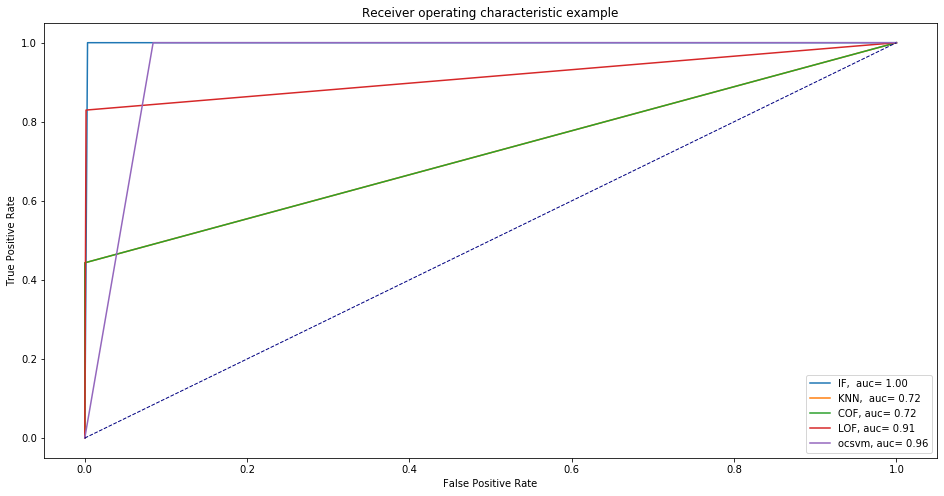

In [115]:
from sklearn import metrics

if_preds = df_test_plot['isolation_forest_outliers']
knn_preds = df_test_plot['KNN_outliers']
cof_preds = df_test_plot['COF_outliers']
lof_preds = df_test_plot['LOF_outliers']
ocsvm_preds = df_test_plot['OCSVM_outliers']


plt.figure(figsize=(16,8)).clf()

pred = if_preds
label = y_test
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="IF,  auc= %0.2f" %(auc))

pred = knn_preds
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="KNN,  auc= %0.2f" %(auc))


pred = cof_preds
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="COF, auc= %0.2f" % (auc))

pred = lof_preds
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="LOF, auc= %0.2f"% (auc))

pred = ocsvm_preds

fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="ocsvm, auc= %0.2f"% (auc))

lw = 1
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")



#### 